## Trojan Detector

### Library import 

In [1]:
import time
import sys
import itertools
import matplotlib.pyplot as plt
from preprocess_data import prepare_data
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils as npu
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import seaborn as sns

### Data Preprocessing 

#### Data Handling


In [2]:
def create_numerics(data):
    nominal_cols = data.select_dtypes(include='object').columns.tolist()
    for nom in nominal_cols:
        enc = LabelEncoder()
        enc.fit(data[nom])
        data[nom] = enc.transform(data[nom])

    return data

In [3]:
def prepare_data():
    data = pd.read_excel("./Data/Trojan_dataset.xlsx")
    data = data.dropna()
    
    trojan_free = data.loc[data['Label']=="'Trojan Free'"].reset_index()    
    for i in range(len(trojan_free)):
        category_substring = trojan_free['Circuit'][i].replace("'",'')
        circuit_group = data[data['Circuit'].str.contains(category_substring)]
        
        df1 = circuit_group.iloc[0:1]
        
        if len(circuit_group) > 1:
            length = len(circuit_group) - 1
            for j in range(length):
                data = pd.concat([data , df1 ], axis = 0)
            # data = data.append([df1]*(len(circuit_group)-1), ignore_index=True)
    
    data.drop(columns=['Circuit'], inplace=True)

    data = create_numerics(data)
    
    data = shuffle(data, random_state=42)
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                      k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    data = data.drop(data[to_drop], axis=1)
    y = pd.DataFrame(data["Label"]).values
    x = data.drop(["Label"], axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    x = scaler.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
    
    
    # plot the correlated features
    return(x_train, x_test, y_train, y_test)

### Feature Correlation 

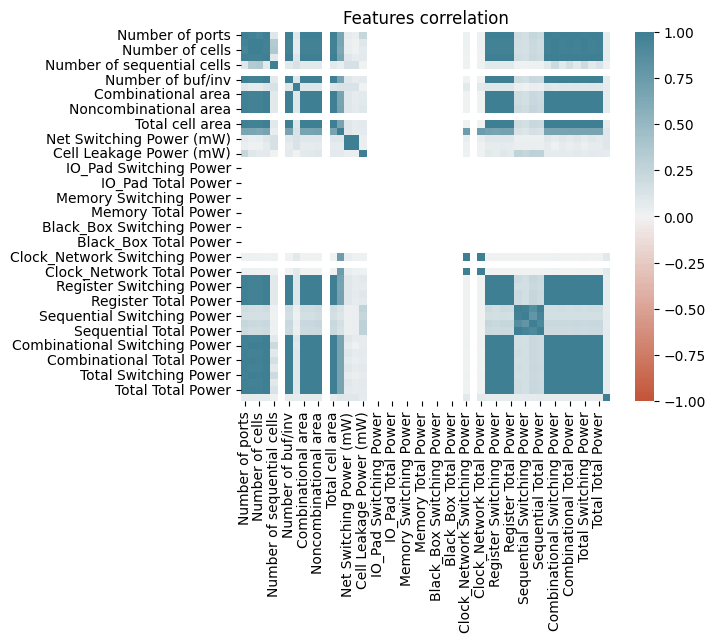

In [4]:
def plot_feature_confusion_matrix():
    data = pd.read_excel("./Data/Trojan_dataset.xlsx")
    data = data.dropna()
    
    trojan_free = data.loc[data['Label']=="'Trojan Free'"].reset_index()    
    for i in range(len(trojan_free)):
        category_substring = trojan_free['Circuit'][i].replace("'",'')
        circuit_group = data[data['Circuit'].str.contains(category_substring)]
        
        df1 = circuit_group.iloc[0:1]
        
        if len(circuit_group) > 1:
            length = len(circuit_group) - 1
            for j in range(length):
                data = pd.concat([data , df1 ], axis = 0)
            # data = data.append([df1]*(len(circuit_group)-1), ignore_index=True)
    
    data.drop(columns=['Circuit'], inplace=True)

    data = create_numerics(data)
    
    data = shuffle(data, random_state=42)
    corr_matrix = data.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                      k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
    data = data.drop(data[to_drop], axis=1)
    y = pd.DataFrame(data["Label"]).values
    x = data.drop(["Label"], axis=1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    x = scaler.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
    
    
    # plot the correlated features
    sns.heatmap(
        corr_matrix,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    plt.title("Features correlation")
    plt.show()

plot_feature_confusion_matrix()

### <b>ML Algorithms and optimization</b>

### MultiLayer Perceptron

Epoch 1/50
212/212 [==============================] - 3s 5ms/step - loss: 0.6058 - mse: 0.2073 - accuracy: 0.7077
Epoch 2/50
212/212 [==============================] - 1s 3ms/step - loss: 0.5829 - mse: 0.1975 - accuracy: 0.7139
Epoch 3/50
212/212 [==============================] - 1s 4ms/step - loss: 0.5623 - mse: 0.1894 - accuracy: 0.7110
Epoch 4/50
212/212 [==============================] - 1s 4ms/step - loss: 0.5307 - mse: 0.1766 - accuracy: 0.7181
Epoch 5/50
212/212 [==============================] - 1s 3ms/step - loss: 0.4865 - mse: 0.1580 - accuracy: 0.7550
Epoch 6/50
212/212 [==============================] - 1s 4ms/step - loss: 0.4344 - mse: 0.1362 - accuracy: 0.8324
Epoch 7/50
212/212 [==============================] - 1s 4ms/step - loss: 0.3811 - mse: 0.1149 - accuracy: 0.8720
Epoch 8/50
212/212 [==============================] - 1s 3ms/step - loss: 0.3335 - mse: 0.0977 - accuracy: 0.8805
Epoch 9/50
212/212 [==============================] - 1s 3ms/step - loss: 0.2998 - mse: 

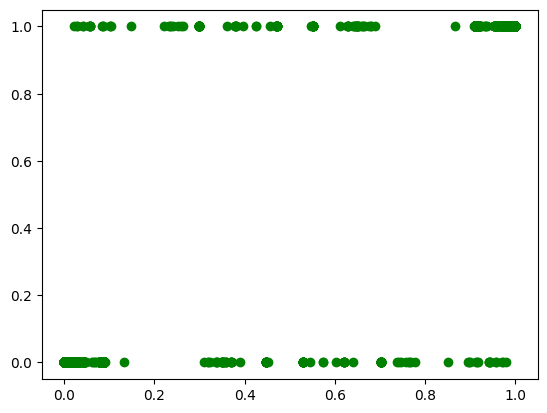

In [5]:
def create_model(train_x, test_y):
    num_classes = test_y.shape[1]

    model = Sequential()

    model.add(Dense(15, input_dim=train_x.shape[1], activation='relu'))

    model.add(Dense(100, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['mse', 'accuracy'])
    return model


train_x, test_x, train_y, test_y = prepare_data()

labels = test_y

train_y = npu.to_categorical(train_y)
test_y = npu.to_categorical(test_y)

model = create_model(train_x, test_y)

start = time.time()
model.fit(train_x, train_y, epochs=50, batch_size=10, shuffle=False)
end = time.time()

y_pred = model.predict(test_x)
predictions = np.argmax(y_pred, axis=1)

correct_class = 0
for i in range(len(labels)):
    if labels[i] == predictions[i]:
        correct_class += 1

mlp_time = end - start
mlp_accuracy = (correct_class / len(labels)) * 100
plt.scatter(y_pred , test_y , color = 'green')
print("### MLP ###\n")
print("Training lasted %.2f seconds" % mlp_time)
print("Accuracy = %.2f" % (mlp_accuracy))

### XG Boost classifier

In [6]:
# XG boost
train_x, test_x, train_y, test_y = prepare_data()
train_y = train_y.reshape((train_y.shape[0], ))

clf = XGBClassifier(n_estimators=20)

start = time.time()
clf.fit(train_x, train_y)
end = time.time()

y_pred = clf.predict(test_x)

xg_time = end - start
xg_accuracy = 100 * accuracy_score(test_y, y_pred)
plt.show()
print("### XGB ###\n")
print("Training lasted %.2f seconds" % xg_time)
print("Accuracy = %.2f" % (xg_accuracy))

### XGB ###

Training lasted 0.09 seconds
Accuracy = 99.56


### Logistic regression

In [7]:
train_x, test_x, train_y, test_y = prepare_data()
train_y = train_y.reshape((train_y.shape[0], ))

clf = LogisticRegression(random_state=0, solver='liblinear', max_iter=300,
                            multi_class='ovr')
start = time.time()
clf.fit(train_x, train_y)
end = time.time()

y_pred = clf.predict(test_x)

log_time = end - start
log_accuracy = 100 * accuracy_score(test_y, y_pred)

print("### LR ###\n")
print("Training lasted %.2f seconds" % log_time)
print("Accuracy = %.2f" % (log_accuracy))

### LR ###

Training lasted 0.02 seconds
Accuracy = 71.81


### Random Forest

### RF ###

Training lasted 0.03 seconds
Accuracy = 99.01
F1-score =  98.78878604406435
Feature: 0, Score: 0.06552
Feature: 1, Score: 0.24553
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.47869
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.01822
Feature: 6, Score: 0.17742
Feature: 7, Score: 0.00718
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00227
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00319
Feature: 24, Score: 0.00196


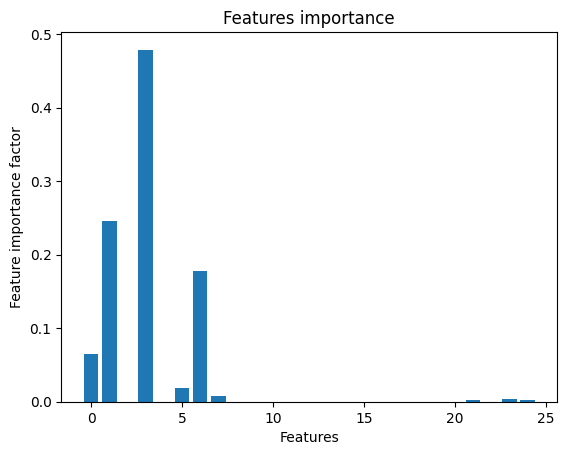

In [8]:
#random Forest    
train_x, test_x, train_y, test_y = prepare_data()
train_y = train_y.reshape((train_y.shape[0], ))
    
clf = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=1)

start = time.time()
clf.fit(train_x, train_y)    
end = time.time()

y_pred = clf.predict(test_x)

rf_time = end - start
rf_accuracy = 100 * accuracy_score(test_y, y_pred)

print("### RF ###\n")
print("Training lasted %.2f seconds" % rf_time)
print("Accuracy = %.2f" % (rf_accuracy))
print("F1-score = ",f1_score(test_y, y_pred, average='macro')*100)
    
importance = clf.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.xlabel('Features')
plt.ylabel('Feature importance factor')
plt.title('Features importance')
plt.show()


### KNN

In [9]:
# KNN
train_x, test_x, train_y, test_y = prepare_data()
train_y = train_y.reshape((train_y.shape[0], ))

clf = KNeighborsClassifier(n_neighbors=3)

start = time.time()
clf.fit(train_x, train_y)
end = time.time()

y_pred = clf.predict(test_x)

k_time = end - start
k_accuracy = 100 * accuracy_score(test_y, y_pred)

print("### KNN ###\n")
print("Training lasted %.2f seconds" % k_time)
print("Accuracy = %.2f" % (k_accuracy))

### KNN ###

Training lasted 0.00 seconds
Accuracy = 99.45


### Confusion matrix

In [10]:
def plot_confusion_matrix(cm, target_names, title, cmap=None, normalize=False):
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Gradient Boost

### GB ###

Training lasted 0.43 seconds
Accuracy = 99.56


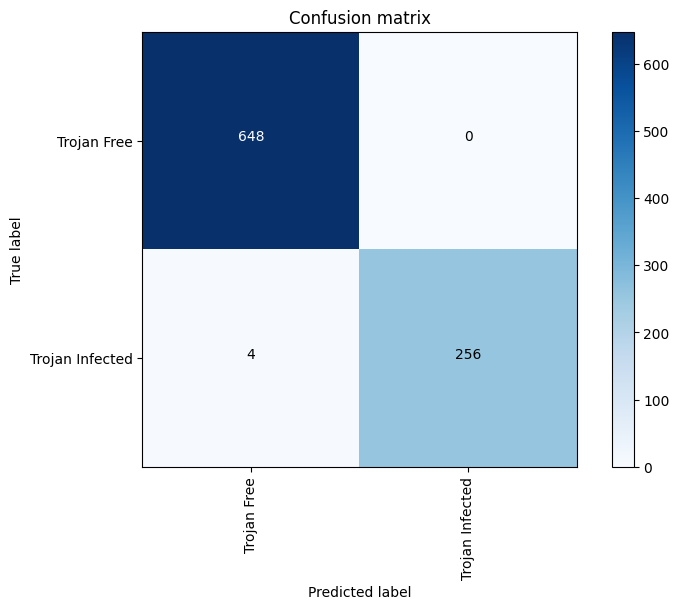

In [11]:
train_x, test_x, train_y, test_y = prepare_data()
train_y = train_y.reshape((train_y.shape[0], ))
    
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=75)

start = time.time()
clf.fit(train_x, train_y)    
end = time.time()

y_pred = clf.predict(test_x)

grad_time = end - start
grad_accuracy = 100 * accuracy_score(test_y, y_pred)

print("### GB ###\n")
print("Training lasted %.2f seconds" % grad_time)
print("Accuracy = %.2f" % (grad_accuracy))

conf_matrix = confusion_matrix(test_y, y_pred)
plot_confusion_matrix(cm=conf_matrix, target_names=['Trojan Free','Trojan Infected'], title='Confusion matrix')

### SVM

In [12]:
#svm
train_x, test_x, train_y, test_y = prepare_data()
train_y = train_y.reshape((train_y.shape[0], ))

classifier = SVC(kernel="rbf", C=10, gamma=1)

start = time.time()
classifier.fit(train_x, train_y)
end = time.time()

y_pred = classifier.predict(test_x)

svm_time = end - start
svm_accuracy = 100 * accuracy_score(test_y, y_pred)

print("### SVM ###\n")
print("Training lasted %.2f seconds" % svm_time)
print("For C : ", 10, ", Gamma: ", 1, ", kernel = rbf",
      " => Accuracy = %.2f" % (svm_accuracy))


### SVM ###

Training lasted 0.35 seconds
For C :  10 , Gamma:  1 , kernel = rbf  => Accuracy = 77.31


### Comparative analysis 

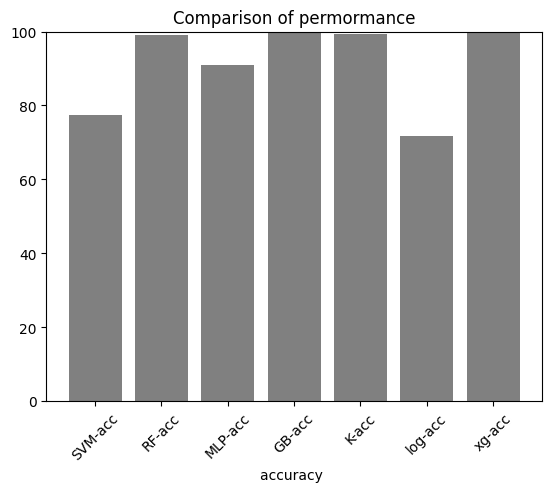

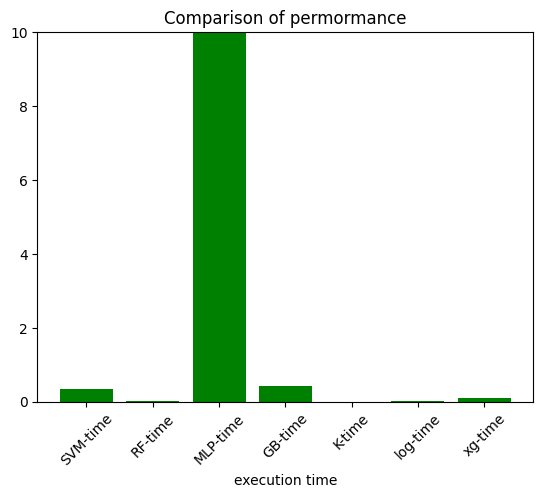

In [13]:

accuracy = [svm_accuracy, rf_accuracy, mlp_accuracy, grad_accuracy,k_accuracy, log_accuracy, xg_accuracy]
time_ = [svm_time, rf_time, mlp_time, grad_time, k_time, log_time, xg_time]

plt.ylim(0, 100)
plt.xlabel("accuracy ")
plt.title("Comparison of permormance")
l1, l2, l3, l4, l5, l6, l8 = plt.bar(["SVM-acc", "RF-acc", "MLP-acc","GB-acc", "K-acc", "log-acc","xg-acc"],accuracy)

plt.xticks(rotation=45)

l1.set_facecolor('gray')
l2.set_facecolor('gray')
l3.set_facecolor('gray')
l4.set_facecolor('gray')
l5.set_facecolor('gray')
l6.set_facecolor('gray')
l8.set_facecolor('gray')

plt.show()
plt.close('all')
plt.ylim(0, 10)
plt.xlabel("execution time")
plt.title("Comparison of permormance")
c1, c2, c3, c4, c5, c6, c8 = plt.bar(["SVM-time", "RF-time", "MLP-time","GB-time", "K-time", "log-time","xg-time"],time_)

c1.set_facecolor('green')
c2.set_facecolor('green')
c3.set_facecolor('green')
c4.set_facecolor('green')
c5.set_facecolor('green')
c6.set_facecolor('green')
c8.set_facecolor('green')

plt.xticks(rotation=45)
plt.show()        